# Soda Bottle Classification with Neural Nets - comparison of 2 approaches

In [1]:
import tensorflow as tf
import keras as keras
from os import listdir

from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
import pandas as pd
from IPython.display import Image
from keras.optimizers import Adam
from keras.layers import (
    GlobalMaxPooling2D,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Bidirectional,
    SpatialDropout2D,
    Input,
    Dropout,
)
from tensorflow.keras.utils import img_to_array, img_to_array, load_img

from sklearn.svm import SVC

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

import glob

import os

from IPython.display import Image, display

import splitfolders

In [2]:
def prepare_image(file):
    img = load_img(file, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

## Illustrating the augmentation process

#### Let's take an example photo:

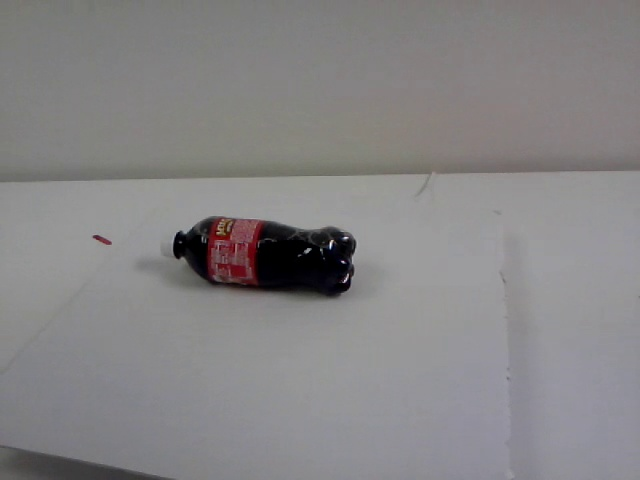

In [3]:
display(Image(filename="example.jpg"))

#### We process it:

In [4]:
example_photo_processed = prepare_image("example.jpg")

In [5]:
example_photo_processed.shape

(1, 224, 224, 3)

#### Let's now define an augmentation generator for our images:

In [6]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

In [7]:
files = glob.glob("preview/*")
for f in files:
    os.remove(f)

In [8]:
i = 0
for batch in datagen.flow(
    example_photo_processed,
    batch_size=1,
    save_to_dir="preview",
    save_prefix="beer",
    save_format="jpeg",
):
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely

#### With this one photo, we are able to generate an arbitrary number of augmented, 'similar' photos that can be used for training a model:

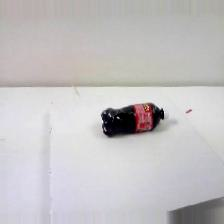

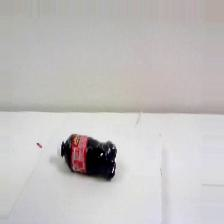

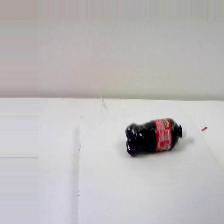

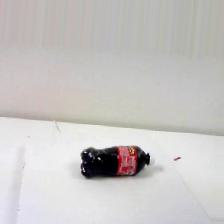

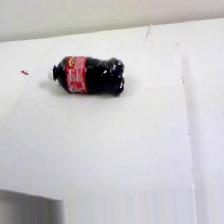

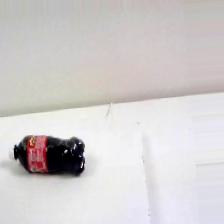

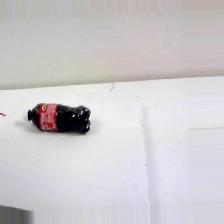

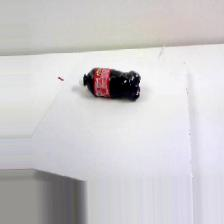

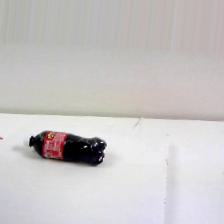

In [9]:
for image_path in glob.glob("preview/*"):
    display(Image(filename=image_path))

#### Regarding data cleaning: The version of the dataset from Kaggle used here is already a corrected one, there are no corrupted files

## Off to actual modelling

#### We first have to split our data into train, validation and test:

In [11]:
splitfolders.ratio("Soda Bottles", output="TVT_split", seed=1337, ratio=(0.8, 0.1, 0.1))

#### We generate a training/test set object with ImageDataGenerator and the augmentation rules illustrated above:

In [12]:
batch_size = 300

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)  # no augmentation for the val and test

In [14]:
train_data = train_datagen.flow_from_directory(  # with augmentation for training
    "TVT_split/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
)

Found 5291 images belonging to 8 classes.


In [15]:
validation_data = (
    test_datagen.flow_from_directory(  # no augmentation for the val and test
        "TVT_split/val",
        target_size=(224, 224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode="categorical",
    )
)

Found 659 images belonging to 8 classes.


In [16]:
test_data = test_datagen.flow_from_directory(  # no augmentation for the val and test
    "TVT_split/test",
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
)

Found 665 images belonging to 8 classes.


### Let's now design a ConvNet to tackle this problem:
#### (check out https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [17]:
model1 = Sequential()

model1.add(
    Conv2D(32, kernel_size=(3, 3), input_shape=(224, 224, 3))
)  # conv_layer=feature_extraction
model1.add(Activation("relu"))  # standard choice of activation
model1.add(MaxPooling2D(pool_size=(2, 2)))  # pooling_layer=feature_selection

model1.add(Dropout(0.2))  # serves as regularization

model1.add(Conv2D(32, (3, 3)))  # conv_layer=feature_extraction
model1.add(Activation("relu"))  # standard choice of activation
model1.add(MaxPooling2D(pool_size=(2, 2)))  # pooling_layer=feature_selection

model1.add(Dropout(0.2))  # serves as regularization

model1.add(Conv2D(64, (3, 3)))  # conv_layer=feature_extraction
model1.add(Activation("relu"))  # standard choice of activation
model1.add(MaxPooling2D(pool_size=(2, 2)))  # pooling_layer=feature_selection

# the model so far outputs 3D feature maps (height, width, features)

model1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model1.add(Dense(128))  # a dense layer for maximal flexibility
model1.add(Activation("relu"))  # standard choice of activation
model1.add(Dropout(0.2))  # serves as regularization
model1.add(
    Dense(8)
)  # final dense layer whose output are the vectorized probs for each class
model1.add(Activation("softmax"))  # since we have 8 categories

model1.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
# we decide to use Adam and accuracy:=(correct_predictions)/(all_predictions)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                        

### Training the first model:

#### (we incorporated validation data in training, so we get immediate feedback on how well our model generalizes on unseen data)

In [20]:
# model1.fit(
#     train_data,
#     steps_per_epoch=train_data.n // train_data.batch_size,
#     epochs=40,
#     validation_data=validation_data,
# )
# model1.save_weights(
#     "model1_nth_try.h5"
# )

# always save your weights after training or during training

#### For conciseness, we will now use the weights we saved after training the model with the code above

In [21]:
model1.load_weights("model1_best_weights.h5")

#### After some hyperparameter tuning, we are satisfied with the validation results and are ready to proceed with testing. This is the sample we touch once and this quantity (accuracy) indicates the performance of our model:

In [22]:
result1 = model1.evaluate(test_data)

3/3 [==============================] - 8s 2s/step - loss: 0.1860 - accuracy: 0.9338


## Accuracy of the first model is cca 93% on the test set

# Transfer Learning

#### Let's now design a Transfer Learning approach to tackle this problem:

#### (check out https://www.educative.io/answers/pre-trained-models-for-transfer-learning-in-keras)

In [23]:
pretrained_model = tf.keras.applications.Xception(  # 36 conv layers, structured into several modules with skip connections
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

In [24]:
pretrained_model.trainable = False  # we first disable the pre-trained part of the net

In [25]:
model2 = Sequential(pretrained_model)

model2.add(
    GlobalAveragePooling2D()
)  # average all the values according to the last axis; standard choice for trans. lear.
model2.add(
    Dense(1024, activation="relu")
)  # dense layer for max flexibility / standard choice of activation
model2.add(Dropout(0.2))
model2.add(
    Dense(512, activation="relu")
)  # dense layer for max flexibility / standard choice of activation
model2.add(Dropout(0.2))
model2.add(
    Dense(256, activation="relu")
)  # dense layer for max flexibility / standard choice of activation
model2.add(Dense(8, activation="softmax"))  # since we have 8 classes

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [26]:
model2.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Training the second model:

#### (we incorporated validation data in training, so we get immediate feedback on how well our model generalizes on unseen data)

In [27]:
# model2.fit(
#     train_data,
#     steps_per_epoch=train_data.n // train_data.batch_size,
#     epochs=40,
#     validation_data=validation_data,
# )

# model2.save_weights(
#     "model2_nth_try.h5"
# )  # always save your weights after training or during training

#### For conciseness, we will now use the weights we saved after training the model with the code above:

In [28]:
model2.load_weights("model2_best_weights.h5")

#### After some hyperparameter tuning, we are satisfied with the validation results and are ready to proceed with testing. This is the sample we touch once and this quantity (accuracy) indicates the performance of our model:

In [29]:
result2 = model2.evaluate(test_data)
print(result2)

3/3 [==============================] - 54s 13s/step - loss: 0.1441 - accuracy: 0.9429
[0.14410024881362915, 0.9428571462631226]


## Accuracy of the second model is cca 94% on the test set

### [OPTIONAL] Let's do some fine tuning now (if you have enough computing power):

In [25]:
pretrained_model.trainable = True  # we enable the training of all layers now

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [28]:
# model2.compile(
#     optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"] # we set a very small learning rate
# )

In [ ]:
# model2.fit(
#     train_data,
#     steps_per_epoch=train_data.n // train_data.batch_size,
#     epochs=1,
#     validation_data=validation_data
# )

In [ ]:
# result2_fine_tuning = model2.evaluate(test_data)

## Defining our final classification rule: Since model2 performed slightly better on the test set, we decide to use that model

In [30]:
label_to_index_map = train_data.class_indices
index_to_label_map = {v: k for k, v in label_to_index_map.items()}
# two maps of practical use

### Example 1 : Pepsi Original

In [31]:
prediction_example1 = model2.predict(prepare_image("pepsi.jpg"))

1/1 [==============================] - 1s 1s/step


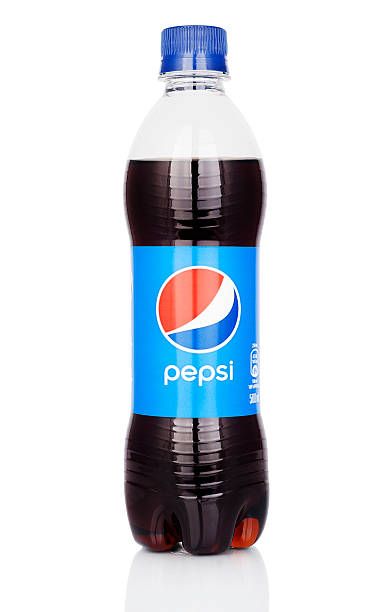

In [32]:
display(Image(filename="pepsi.jpg"))

In [33]:
print("The probs of what is on the picture is as follows")
for i in range(8):
    print(
        index_to_label_map[i] + " : " + str("{0:.3f}".format(prediction_example1[0][i]))
    )

The probs of what is on the picture is as follows
M.Beer : 0.003
MD.Diet : 0.119
MD.Orig : 0.027
P.Cherry : 0.238
P.Orig : 0.609
P.Rsugar : 0.002
P.Zero : 0.002
P.diet : 0.000


### Wonderful! It correctly sees the it is indeed Pepsi Original.